# Naive Bayes Classifier Tutorial
 
In this tutorial we will look at how to detect patterns using Bayes Naive Classifier, which is a machine learning technique that is great at detecting patterns and predicting dependencies in your data set.

In the first secction of this training we will revisit the Iris flower data set fromt he previous tutorial to learn the minimum steps to work with the Naive Bayes Classifier. Next, we will apply what you have learned to detect SPAM in SMS messaging (texts) in order to predict which messages you will not want to read. The data set we will use for this is the [SMS Spam collection]  https://doi.org/10.24432/C5CC84, an Open Source data set in the UCI Machine Learning Repository. Then we move on to multi-label classification using the CMU book data set that we used for K-nearest neighbours too. Finally, we'll show you an example of using Naive Bayes in such a way that it actually fails and we'll explain why.

## Learning Objectives

 Average time to complete: 120 minutes
 
 By the end of this tutorial you should be able to:
 * Understand what Naive Bayes classifier is.
 * Split the data into training and testing sets.
 * Make prediction on the data set.
 * Evaluate the performance of a classifier.
 * Use Naive Bayes classifier to detect spam and classify books.
 * Train a Gaussian Naive Bayes classifier for single or multiple labels.
 * Use imputation by fitting a curve to known data and use the results to fill in missing data. 

 
## What you will need for this tutorial

* See the [introduction document](https://uottawa-it-research-teaching.github.io/machinelearning/) for general requirements and how Jupyter notebooks work.
* We'll need Pandas for convenient data handling. It's a very powerful Python package that can read CSV and Excel files. It also has very good data manipulation capabilities which come in use for data cleaning. We'll use that in combination with the JSON package for reading data.
* We will use scikit-learn, SciPy and NumPy as our machine learning packages and Seaborn and matplotlib as our plotting tools.
* The data files that should have come with this notebook.

## RDM best practices

Good data handling for machine learning begins with good Research Data Managment (RDM). The quality of your source data will impact the outcome of your results, just like the reproducibility of your results will depend on the quality of your data sources, in addition to how you organize the data so that other people (and machines!) can understand and reuse it.

We also need to respect a few research data management best practices along the way, these best practices are recommended by the [Digital Research Alliance of Canada](https://zenodo.org/records/4000989). In the first and second tutorial, we encouraged you to resepct three RDM best practices:

* SAVE YOUR RAW DATA IN ORIGINAL FORMAT<br>
* BACKUP YOUR DATA (3-2-1 rule)<br>
* DESCRIBE YOUR DATA

These practices should apply in this tutorial as well, but we will also look at best practices for structuring your data file which will improve the accuracy of your machine learning model and will improve reuse of the data set in future work.

PROCESS YOUR DATA
* Make each column a variable.
* Make each row an observation.
* Store units (e.g. kg or cm) as metadata (in their own column).
* Document each step processing your data in a README file.

These are a few RDM best practices that will help you in your project management, more are highlighted at the beginning of  each tutorial in this series. 

## What is the Naive Bayes Classifer?
Naive Classifier is a family of classifiers based on Bayes' Theorem.
$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

What this formula tells us is that we can calculate the probability of event $A$ given that $B$ happened, i.e. $P(A|B)$. In the context of machine learning this means that it can find the probability for a certain label to be attributed to the raw data, given the input data of the data point we are trying to predict. In machine learning, labeling the raw data is a necessary preparatory step to specify the context of the data for the models. The label is like an instruction to the computer on how to understand the context of the data point when processing the dataset. Data labeling is time consuming, so using a prediction model can save you time. 

$$\frac{P(B|A)P(A)}{P(B)}$$ is what we can predict through training the model. The numerator (above the line) is effectively the probability of $A$ and $B$ both happening. You can extend this formula to have many more events, so you get the probability of $A$ happening given $B$, $C$, $D$, etc., i.e. $P(A|B,C,D,...)$.

In the context of machine learning, this formula helps us predict an attribute of our data set, based on the probabilities of features $x_1, x_2, x_3, ...$  (if the features are all independent). In machine learning and pattern recognition, a feature is an individual measurable property or attribute of a data point. Independent features (ie. not modified by another data point) are recommended for accurate results in pattern recognition models.

But what if there are dependecies between the data points? For example, the weather data in the first tutorial (Data Cleaning and Regression). When your data is weather data, then the temperature data points will modify the precipitation data points (rain and snow). The Naive Bayes Classifier works remarkably well even if there is a bit of dependence between the features.  That's why it's call **Naive** Bayes.

In [1]:
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import scipy.optimize

## 1. Using the Naive Bayes Classifier

The classic Iris flower data set that you saw in the previous tutorial about Decision Trees and Random Forests works very well with the Naive Bayes classifier as well. This data set describes hundreds of species of plants in the family Iridaceae, which would take a long time to manually identify and label for machine learning, so we want to create a model that can help us predict which label should be attributed to features describing a class of iris flower. This data set has petal length and other physical properties linked to the type of iris.

This data set also follows good RDM practices because the variables of each column are clearly named, and each row records a singular observation as a data point. The sepal and the petal are two distinct parts to the Iris flower. In this data set structure, sepal_length, sepal_width, petal_length, petal_width are easily parsed by a computational model as dependent data points (length influences width). But the computational model does not have contextual horticultural knowledge to label these features of the species; instead, we have to teach it how to predict the species according to the probability of that species having these features.

For this section, you will learn the minimum amount of steps to use the Naive Bayes classifier. In the later sections we will expand on this.

The first step of working with any data set is of course loading the data! Since the Iris dataset is such a well-used dataset in machine learning tutorials, it is even included in some of the libraries. Here we use Seaborn that has it included. It has two columns that we care about, "data" and "target". The first are our features, i.e. the input for our machine learning algorithm which we store in the variable `X`. These will be petal length, sepal length and such. The second is the output of our machine learning algorithm. These are the labels we are trying to predict which we'll store in the variable `y`. These are the names of the flowers. `iris.target_names` will list those.

In [2]:
iris = datasets.load_iris()
X = iris['data']  # features
y = iris['target']  # labels
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

By running the code below, we are going to split our data set into training and testing set which you almost always need to do for any machine learning algorithm because it allows you to set aside a bit of data that the model is not being trained on. You can then use that later to qualify the accuracy on the model by feeding that data to the trained model and comparing the predicted output to what you know the output should be.

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

The most common Naive Bayes classifier is the Gaussian one. It makes the assumption that the input data is normally distributed, i.e. follow a Guassian distribution, which is very often the case. There are some more specialized ones for different distributions, but we'll exclusively use the Guassian one here.

First we need to create the model with the `GaussianNB()` function. Then we can use the `fit` function of that model to fit (train) it to the data.

A small note on Jupyter notebooks, you may see text like about trusting the notebook. This just means you need to run the code yourself to see the results. It's a security feature of Jupyter.

In [4]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

Now that our model is trained, we can use it to predict labels. We'll use the part of the dataset we set aside earlier. That is, the model has specifically not been trained on `X_test`.

In [5]:
y_pred = gnb.predict(X_test)

The predictions of the model can now be compared to the actual labels. This allows us to evaluate the performance of the model on data it has not seen before.

In [6]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


So, 100% accuracy. Our predicted labels match exactly the real labels. In practise a 100% accuracy is highly suspicious since it's just too perfect. However, the Iris dataset is in so many tutorials for a reason since it is such a perfect dataset.

Time to move on to something more challenging. We'll use a database of text messages and try to determine if those messages are spam or not.

## 2. Naive Bayes Classifier for predicting SMS Spam

One of the common applications of Naive Bayes is in detecting spam. It's a very fast method which is good since roughly 50% of all emails sent globally are spam! Text messages cost money to send, so the rate SMS spam messages is lower. Either way, it's really annoying!

One way of filtering spam is to train the model to recognize words commonly used by spammers, which are different enough from words commonly used in real messages.The data set we will use for this is the [SMS Spam collection]  https://doi.org/10.24432/C5CC84, an Open Source data set in the UCI Machine Learning Repository. 

This data set follows RDM best practices for documentation, so we know the data set is a compilation of multiple sources, including a labour-intensive process of mannually extracting SPAM messages posted to a web forum where people make complaints. We can also understand the data structure from this documentation, which uses a pun in the variable name spam_or_ham. This is a pun that can only be understood by an English language speaker that knows the difference between ham (a cut of meat derived from hogs) and SPAM (a processed version of ham, considered to be of lesser quality and dubious origin). 

The dataset is part of this repository and you should be able to see it in the data subdirectory. Let's read the data using Pandas. The format of the data is tab-separated values, so we need to specify that we use a Tab characters which are encoded as `\t`. This file also doesn't have a header, so we create our own column names.

In [7]:
textmessages = pd.read_csv('data/SMSSpamCollection', sep='\t', header=None, names=['spam_or_ham','text'])
textmessages.head(10)

,spam_or_ham,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


We would like to look at word frequencies. Messages that have a lot of "bad" words will be more likely to be spam, messages with a lot of "good" words are probably real messages, or ham. So we need to label these words to train the computer with a judgement value of "good" or "bad" and, then we ask it to count words and classify as spam or ham. Fortunately, scikit-learn comes with a feature extractor exactly for that called `CountVectorizer`.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

Now take all of the words in all of the text messages to create a dictionary. Then for each text messages, count how often each words appears in that particular message.

In [9]:
count_vect = CountVectorizer()
X = count_vect.fit_transform(textmessages.text)

In [10]:
X

<5572x8713 sparse matrix of type '<class 'numpy.int64'>'
	with 74169 stored elements in Compressed Sparse Row format>

So there are 74,169 unique words in the complete dataset. Each word has a frequency which is the input for our model. That's a lot of features! Fortunately, dealing with lots of features is one of the strong point of Naive Bayes. So it's not specifically single words being good or bad but it all the combinations.

Then we just need the labels which is 'spam' or 'ham'. Then split the training set and feed the train data to the model to train on.

In [11]:
y = textmessages['spam_or_ham']

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.2, random_state=42)

In [13]:
# Train a Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

We now have a trained model that can take any text message and label it as either spam or ham. Let's see what the accuracy is.

In [14]:
# Make predictions on the test set
y_pred = gnb.predict(X_test)

In [15]:
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9067264573991032


Roughly 90% so that's pretty decent. This is the percentage of correct predicitions, however there is more to evaluating a model than that. Since this is a spam filter, you may consider false positives (labeled as spam when it's not) be worse than false negatives (labeled as ham when it's not).

For that, we can use a confusion matrix. It will tell you how many spam messages were correctly classified and not and how many ham messages were correctly classified and not.

In [16]:
confusion_matrix(y_test, y_pred)

array([[873,  93],
       [ 11, 138]])

We can plot this to make it more understandable.

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

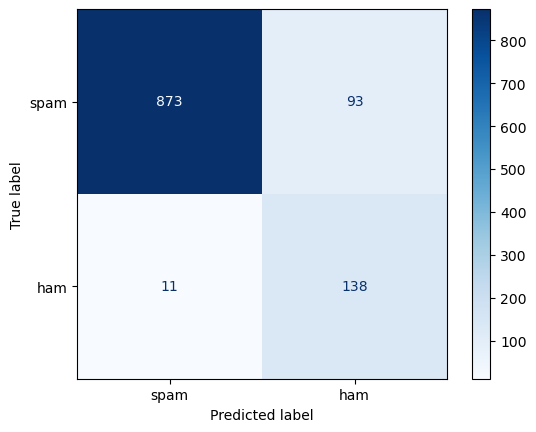

In [18]:
ConfusionMatrixDisplay.from_estimator(
        gnb,
        X_test,
        y_test,
        display_labels=["spam","ham"],
        cmap=plt.cm.Blues,
#        normalize=normalize,
    )

From this, we can see that 11 messages were predicted to be spam even though it was ham. This is the number you want to as close to zero as possible because if you use this filter to automatically delete messages classified as spam, this would result in lost messages which is much worse than having to manually delete the occasional spam message that gets through.

We have now trained a Naive Bayes classifier to predict just a single label. Let's make it a bit more complicated again and have it train for multiple labels.

## 3. Book genres

In this section, we'd like to make a model than can automatically figure out what genres a book belongs to based on a summary of the book. However, a book can belong to multiple genres which is different from what we had with the Iris dataset where each data point could only have one label.

### Data
We will use the CMU Book Summary Dataset from https://www.cs.cmu.edu/~dbamman/booksummaries.html. You don't need to download it yourself since it's already included in the data subdirectory that comes with this notebook.

This dataset is tab separated without a header row, similar to the SMS dataset we had before. We can get the column names from the README at the link above.

In [19]:
books = pd.read_csv('data/booksummaries.txt', sep="\t", header=0, names=['wikipedia', 'freebase', 'title', 'author', 'publicationdate', 'genres', 'summary'])

This dataset has a fair number of missing values. We could do some more work to improve this dataset, however we'll just be lazy and drop any rows with missing data. Then we show the first ten rows of the dataset using the `head()` function to get an idea of what the data looks like.

In [20]:
books = books.dropna()
books.head()

,wikipedia,freebase,title,author,publicationdate,genres,summary
0,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
1,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"{""/m/098tmk"": ""War novel"", ""/m/016lj8"": ""Roman...","The book tells the story of Paul Bäumer, a Ge..."
5,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"{""/m/0dwly"": ""Children's literature"", ""/m/01hm...","Ged is a young boy on Gont, one of the larger..."
7,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"{""/m/06n90"": ""Science Fiction"", ""/m/014dfn"": ""...","Living on Mars, Deckard is acting as a consul..."


Genres are in a JSON format, so we will need the JSON package to extract those.

In [21]:
import json

Convert that JSON into a simple list. We don't care about the weird identifiers.

In [22]:
def genre(row):
    g = json.loads(row.genres)
    return list(g.values())

genresperbook = books.apply(genre, axis=1)
books = books.assign(genres=genresperbook)

We'll use the `head` function again on the books dataset to see the first ten rows. We can see we have a new column called "genres" now that has the list of genres.

In [23]:
books.head()

,wikipedia,freebase,title,author,publicationdate,genres,summary
0,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan..."
1,986,/m/0ldx,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...
4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge..."
5,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"[Children's literature, Fantasy, Speculative f...","Ged is a young boy on Gont, one of the larger..."
7,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul..."


### 3.1 Feature extraction
We now want to predict multiple labels. One way we can do this is by creating a dummy column. A dummy column is a new column for each label that has the value 0 if the book is not part of that genre and a 1 if it is. This way you get independent features that can be predicted.

The following code does that. It's fairly dark magic and full transparency, I just copied it mostly from StackOverflow, but what it does is that it takes the lists in the genres column and converts them to a Pandas Series. Then, it stacks them one on the other while keeping the main index but with a sub index for each genre per book. Then, we get the dummies for that. The result of that is still a multi-index DataFrame but now with a column for every genre per book per listed genre for that book.

We need to collapse that back into a single-index DataFrame again, so we group all that by the first index of our multi-index DataFrame which is the index for the books. We sum on that which means that per book we now have a single row that has a 1 if that book is part of a certain genre and 0 if not. Then we add a prefix to the column name.

In [24]:
dummies = books.genres.apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('genre_')
books = books.join(dummies)

In [25]:
books

,wikipedia,freebase,title,author,publicationdate,genres,summary,genre_Absurdist fiction,genre_Adventure,genre_Adventure novel,...,genre_Utopian fiction,genre_Vampire fiction,genre_War novel,genre_Western,genre_Western fiction,genre_Whodunit,genre_Wuxia,genre_Young adult literature,genre_Zombie,genre_Zombies in popular culture
0,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"[Science Fiction, Novella, Speculative fiction...","Alex, a teenager living in near-future Englan...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,986,/m/0ldx,The Plague,Albert Camus,1947,"[Existentialism, Fiction, Absurdist fiction, N...",The text of The Plague is divided into five p...,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2152,/m/0x5g,All Quiet on the Western Front,Erich Maria Remarque,1929-01-29,"[War novel, Roman à clef]","The book tells the story of Paul Bäumer, a Ge...",0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,2890,/m/011zx,A Wizard of Earthsea,Ursula K. Le Guin,1968,"[Children's literature, Fantasy, Speculative f...","Ged is a young boy on Gont, one of the larger...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,4081,/m/01b4w,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,"[Science Fiction, Speculative fiction]","Living on Mars, Deckard is acting as a consul...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16548,36372465,/m/02vqwsp,The Third Lynx,Timothy Zahn,2007,[Science Fiction],The story starts with former government agent...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16550,36534061,/m/072y44,Remote Control,Andy McNab,1997,"[Thriller, Fiction, Suspense]",The series follows the character of Nick Ston...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16554,37054020,/m/04f1nbs,Transfer of Power,Vince Flynn,2000-06-01,"[Thriller, Fiction]",The reader first meets Rapp while he is doing...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16555,37122323,/m/0n5236t,Decoded,Jay-Z,2010-11-16,[Autobiography],The book follows very rough chronological ord...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Phew!! Now the data is in a form we can use for the labels.

Let's look a bit closer at the genres and in particular how many books we have in each category. We'll just sum the dummy columns for genres.

In [26]:
genreusage = books.drop(['wikipedia', 'freebase', 'author', 'publicationdate', 'genres', 'title', 'summary'], axis=1).sum().sort_values(ascending=False)
genreusage

genre_Fiction                3674
genre_Speculative fiction    3270
genre_Novel                  2088
genre_Science Fiction        2001
genre_Fantasy                1863
                             ... 
genre_Prose                     1
genre_Photography               1
genre_Indian chick lit          1
genre_Superhero fiction         1
genre_Neuroscience              1
Length: 215, dtype: int64

So there are a whole bunch of genres that only have one book in the dataset. As you can imagine, this is not going to work well when training the model. So let's put in a lower limit of say 200. How many genres do we have still?

In [27]:
genreusage = genreusage.reset_index().rename(columns={0: "count"})
genreusage = genreusage[genreusage["count"] > 200]
genreusage

,index,count
0,genre_Fiction,3674
1,genre_Speculative fiction,3270
2,genre_Novel,2088
3,genre_Science Fiction,2001
4,genre_Fantasy,1863
5,genre_Children's literature,1627
6,genre_Mystery,973
7,genre_Young adult literature,625
8,genre_Crime Fiction,557
9,genre_Historical novel,551


There are 16 genres left. We can train our model to recognize those hopefully. Let's get rid of the counts and just have a list of genres we can work with. We can then use the list to select only those dummy columns and disregard the others.

In [28]:
genretrainlist = list(genreusage["index"])
genretrainlist

['genre_Fiction',
 'genre_Speculative fiction',
 'genre_Novel',
 'genre_Science Fiction',
 'genre_Fantasy',
 "genre_Children's literature",
 'genre_Mystery',
 'genre_Young adult literature',
 'genre_Crime Fiction',
 'genre_Historical novel',
 'genre_Suspense',
 'genre_Thriller',
 'genre_Horror',
 'genre_Romance novel',
 'genre_Historical fiction',
 'genre_Adventure novel']

In [29]:
dummies = dummies[genretrainlist]

### 3.2 Input
Next is the input. These are the summaries for a book which is essentially a collection of words. We can vectorize that by making a vector that has a length of however many unique words there are in all the summaries combined. Then each book summary can be represented as a vector that counts the number of words.

That sounds complicated to do, but fortunately, scikit-learn can do it for us like it did for the SMS messages before.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [31]:
count_vect = CountVectorizer()

In [32]:
X = count_vect.fit_transform(books.summary)

Let's look at the first transformed book summary now.

In [33]:
X[0]

<1x90759 sparse matrix of type '<class 'numpy.int64'>'
	with 486 stored elements in Compressed Sparse Row format>

It is using a dictionary of 90759 words and it had 486 words in the summary.

Machine learning models like it when everything is between 0 and 1 as this aids feature comparisons is everything is scaled to a similar scale. Additionally, if commonly used words can be scaled down a bit, that would help too since if words appear in every summary then they will not effect for classification. We can change to normalized word frequencies by using the `TfidfTransformer`. "TFIDF" stands for Term-Frequency times Inverse Document-Frequency. The inverse document frequency takes care of scaling often-used words down.

In [34]:
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X)

### Train

Now that our data is in a suitable for for feeding to the model, we can start with the training. Let's recall which genres we are training for. These are the columns in our dummies dataset.

In [35]:
dummies.columns

Index(['genre_Fiction', 'genre_Speculative fiction', 'genre_Novel',
       'genre_Science Fiction', 'genre_Fantasy', 'genre_Children's literature',
       'genre_Mystery', 'genre_Young adult literature', 'genre_Crime Fiction',
       'genre_Historical novel', 'genre_Suspense', 'genre_Thriller',
       'genre_Horror', 'genre_Romance novel', 'genre_Historical fiction',
       'genre_Adventure novel'],
      dtype='object')

For each of these genres, we can train the model. Effectively, we have one model for each genre. We use a `for` loop to loop over the genres and get a model that says if that book is in that particular genre or now.

Be aware that this part is very memory intensive. The `X.toarray()` function below requires a lot of memory to expand the data into a form that `GuassianNB` can use. The code below will crash if you do not have enough memory.  So make sure you choose an appropriate value for `maxbooks`. Setting that value lower will reduce the amount of memory used, but it will also train the model on less books making it less accurate.

In [36]:
for col in dummies.columns:

    # How many books to use for the training
    maxbooks = 10000    # If you machine > 32 GB, use this
    #maxbooks = 4000    # If you machine has 16 GB, use this
    #maxbooks = 2000    # If you machine has 8 GB, use this

    # Split the data into training and testing sets
    y = dummies[col][:maxbooks]
    X_train, X_test, y_train, y_test = train_test_split(X.toarray()[:maxbooks], y, test_size=0.2, random_state=42)

    # Train a Gaussian Naive Bayes classifier
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = gnb.predict(X_test)
    
    # Evaluate the performance of the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {col}: {accuracy}")

Accuracy for genre_Fiction: 0.5739644970414202
Accuracy for genre_Speculative fiction: 0.6847767616998386
Accuracy for genre_Novel: 0.7294244217321141
Accuracy for genre_Science Fiction: 0.7998924152770307
Accuracy for genre_Fantasy: 0.8579881656804734
Accuracy for genre_Children's literature: 0.8235610543302851
Accuracy for genre_Mystery: 0.8864981172673481
Accuracy for genre_Young adult literature: 0.9268423883808499
Accuracy for genre_Crime Fiction: 0.933835395373857
Accuracy for genre_Historical novel: 0.9381387842926304
Accuracy for genre_Suspense: 0.9268423883808499
Accuracy for genre_Thriller: 0.9526627218934911
Accuracy for genre_Horror: 0.9558902635825712
Accuracy for genre_Romance novel: 0.958041958041958
Accuracy for genre_Historical fiction: 0.9558902635825712
Accuracy for genre_Adventure novel: 0.9714900484131254


Looks like we can predict most genres pretty well! Especially when compared to the KNN we tried using before. It does have a lot of trouble prediction "Fiction". This might be because that label is probably too generic. As in lots of different genres can be classified as fiction.

The difference between Naive Bayes and K-nearest neighbours is that Naive Bayes works particularly well with loads and loads of input columns whereas that is exactly where KNN breaks down. This is a good example of the consequences of model choice.

## 4. School grades

Ontario produces open data sets with statistics for schools. We can download it from their catalogue. Note that this example is one of **FAILURE**. We will go through the steps and learn a bit more about imputation along the way. At the end, we'll discuss why it probably didn't work.

### 4.1 Data cleaning

The data set we use from the [Ontario Data Catalogue](https://data.ontario.ca/dataset/school-information-and-student-demographics/resource/e0e90bd5-d662-401a-a6d2-60d69ac89d14) contains demographical data for all the schools in Ontario. It comes in the form of an Excel spreadsheet which Pandas will be able to read.

In this dataset, they indicate missing data with "NA" but there is also "SP" which means the enrollment was too low to report data on student performance without privacy concerns. We'll tell pandas to treat both "SP" and "NA" as missing values. They also have "N/D" and "N/R" which are just special cases of "NA" so we can treat those as missing data as well.

In [37]:
schools = pd.read_excel('data/new_sif_data_table_2021_22prelim_en_november2023.xlsx', na_values=["NA","SP", "N/D", "N/R"])

Let's see what we have in terms of data quality.

In [38]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 49 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Board Number                                                                      4904 non-null   object 
 1   Board Name                                                                        4904 non-null   object 
 2   Board Type                                                                        4904 non-null   object 
 3   School Number                                                                     4904 non-null   object 
 4   School Name                                                                       4904 non-null   object 
 5   School Type                                                                       4904 non-null   object 
 6   

Many columns seem to have no data at all. Some are just a bit poor. Some contain address information and websites. We can drop many of those. Let's start with dropping names, addresses and ID numbers.

In [39]:
schools = schools.drop([
    'Board Number',
    'Board Name',
    'Board Type',
    'School Number',
    'School Name',
    'School Special Condition Code',
    'Building Suite',
    'P.O. Box',
    'Street',
    'Municipality',
    'City',
    'Province',
    'Postal Code',
    'Phone Number',
    'Fax Number',
    'School Website',
    'Board Website',
    'Longitude',
    'Latitude',
    'Extract Date'
], axis=1)

In [40]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 29 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   School Type                                                                       4904 non-null   object 
 1   School Level                                                                      4904 non-null   object 
 2   School Language                                                                   4904 non-null   object 
 3   Grade Range                                                                       4904 non-null   object 
 4   Enrolment                                                                         4677 non-null   float64
 5   Percentage of Students Whose First Language Is Not English                        4677 non-null   float64
 6   

We still have rather a lot of columns with no data at all. Let's drop those as well.

Actually, let's also get rid of the columns that have fewer than 1000 valid values.

In [41]:
schools = schools.dropna(thresh=1000, axis=1)

In [42]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 19 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   School Type                                                                       4904 non-null   object 
 1   School Level                                                                      4904 non-null   object 
 2   School Language                                                                   4904 non-null   object 
 3   Grade Range                                                                       4904 non-null   object 
 4   Enrolment                                                                         4677 non-null   float64
 5   Percentage of Students Whose First Language Is Not English                        4677 non-null   float64
 6   

There is still another issue. Some of the percentages in the spreadsheet are written as "89%" instead of just the number "89", so pandas thinks it's text. Let's fix that for each bad column by removing the "%" sign and reinterpreting the column as a "float64" or in other words, a number that can have decimals.

In [43]:
for badcol in [
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Reading",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Reading",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics",
]:
    schools[badcol] = schools[badcol].str.rstrip('%').astype('float64')

In [44]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 19 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   School Type                                                                       4904 non-null   object 
 1   School Level                                                                      4904 non-null   object 
 2   School Language                                                                   4904 non-null   object 
 3   Grade Range                                                                       4904 non-null   object 
 4   Enrolment                                                                         4677 non-null   float64
 5   Percentage of Students Whose First Language Is Not English                        4677 non-null   float64
 6   

Let's see if we can do some imputation on the columns that have only 3300 to 3500 values. To be able to do that, we first need to get a sense of how the data is distributed. One of the easier ways of getting a sense of things is to plot them. Here, we'll use histograms.

array([[<Axes: title={'center': 'Percentage of Grade 3 Students Achieving the Provincial Standard in Reading'}>],
       [<Axes: title={'center': 'Percentage of Grade 3 Students Achieving the Provincial Standard in Writing'}>],
       [<Axes: title={'center': 'Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics'}>],
       [<Axes: title={'center': 'Percentage of Grade 6 Students Achieving the Provincial Standard in Reading'}>],
       [<Axes: title={'center': 'Percentage of Grade 6 Students Achieving the Provincial Standard in Writing'}>],
       [<Axes: title={'center': 'Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics'}>]],
      dtype=object)

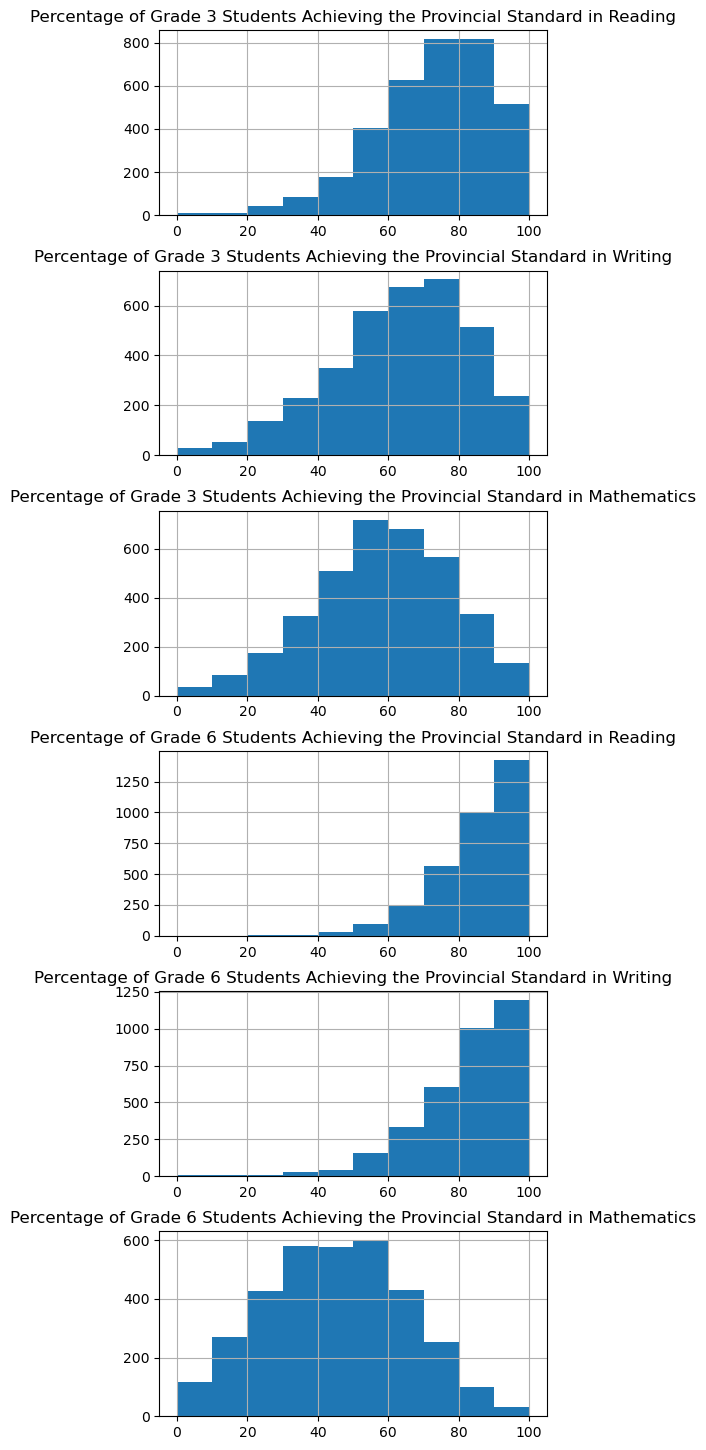

In [45]:
schools[[
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Reading",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Reading",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics",
]].hist(layout=(6,1), figsize=(5,18))

That all looks quite close to normal distributions, albeit cut off since a percentage needs to be between 0 and 100. But that's interesting. It means that very likely missing values will follow this same distribution. So we could potentially impute by filling in the missing values by taking random values from this distributions.

To be able to do that, we first need to get the curve that described this distribution. We can do that by fitting a mathematical function to the data. This mathematical function will be the formula for a normal distribution since we see that the data looks like that. So let's get the data for these histograms using NumPy.

The `np.histogram` function produces the bounds rather than the actual x coordinate, so we need to drop the last entry and move everything to the right by half an interval. That way, we get the array of x and y to be the same size which we need for fitting and plotting. The resulting data would look exactly like the above histograms when plotted.

In [46]:
yhist, xhist = np.histogram(schools["Percentage of Grade 6 Students Achieving the Provincial Standard in Reading"].dropna(), bins=20)
xhist=xhist.copy()
xhist.resize(len(xhist)-1)
xhist = xhist + (xhist[1] - xhist[0]) / 2

Now we can fit a normal distribution to this. It has three parameters, the amplitude, the mean (mu) and the standard deviation (sigma). The last argument for `p0` sets some starting conditions.

In [47]:
res = scipy.optimize.curve_fit(lambda x, A, mu, sigma: A*scipy.stats.norm.pdf(x, loc=mu, scale=sigma), xhist, yhist, p0 = [1000, 60, 20])
amplitude, mu, sigma = res[0]
res[0]

array([4.37026715e+04, 1.06125916e+02, 2.08856249e+01])

Let's see how that looks. We'll plot the fitted curve on the same graph as the histograms we plotted before. Here we only take the one for "Percentage of Grade 6 Students Achieving the Provincial Standard in Reading" and we made the histogram orange so we can see the fitted curve better.

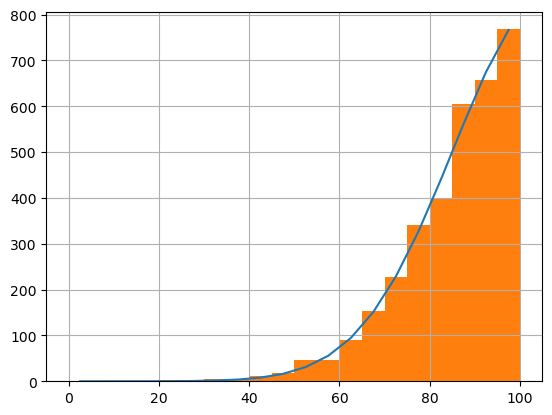

In [48]:
fig, ax = plt.subplots(1, 1)
ax.plot(xhist, amplitude*scipy.stats.norm.pdf(xhist, loc=mu, scale=sigma))
schools["Percentage of Grade 6 Students Achieving the Provincial Standard in Reading"].hist(bins=20)
plt.show()

That's pretty good. Now let's use that distribution to generate random values to fill in for our missing values. We'll use `trucnnorm` which is a truncated version so that we can guarantee that the numbers fall between 0 and 100. The `bounds` argument that function takes is in terms of standard deviations though so we need to do some math!

In [49]:
missingdatafiller = pd.DataFrame(scipy.stats.truncnorm((0 - mu) / sigma, (100 - mu) / sigma, loc = res[0][1], scale=res[0][2]).rvs(len(schools)), columns=["Percentage of Grade 6 Students Achieving the Provincial Standard in Reading"])
schools = schools.fillna(missingdatafiller)

In [50]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 19 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   School Type                                                                       4904 non-null   object 
 1   School Level                                                                      4904 non-null   object 
 2   School Language                                                                   4904 non-null   object 
 3   Grade Range                                                                       4904 non-null   object 
 4   Enrolment                                                                         4677 non-null   float64
 5   Percentage of Students Whose First Language Is Not English                        4677 non-null   float64
 6   

Excellent, that column for "Percentage of Grade 6 Students Achieving the Provincial Standard in Reading" is now completely filled. Let's do the five other columns as well for which we plotted the histograms earlier.

In [51]:
for badcol in [
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Reading",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Writing",
    "Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics",
]:
    yhist, xhist = np.histogram(schools[badcol].dropna(), bins=20)
    xhist=xhist.copy()
    xhist.resize(len(xhist)-1)
    xhist = xhist + (xhist[1] - xhist[0]) / 2

    res = scipy.optimize.curve_fit(lambda x, A, mu, sigma: A*scipy.stats.norm.pdf(x, loc=mu, scale=sigma), xhist, yhist, p0 = [1000, 60, 20])
    amplitude, mu, sigma = res[0]

    missingdatafiller[badcol] = scipy.stats.truncnorm((0 - mu) / sigma, (100 - mu) / sigma, loc = res[0][1], scale=res[0][2]).rvs(len(schools))
schools = schools.fillna(missingdatafiller)

In [52]:
schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4904 entries, 0 to 4903
Data columns (total 19 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   School Type                                                                       4904 non-null   object 
 1   School Level                                                                      4904 non-null   object 
 2   School Language                                                                   4904 non-null   object 
 3   Grade Range                                                                       4904 non-null   object 
 4   Enrolment                                                                         4677 non-null   float64
 5   Percentage of Students Whose First Language Is Not English                        4677 non-null   float64
 6   

Cool, that is a nice chunk of data. For the other columns, there isn't too much data missing, so lets just drop the missing values for those.

In [53]:
schools = schools.dropna()
schools

,School Type,School Level,School Language,Grade Range,Enrolment,Percentage of Students Whose First Language Is Not English,Percentage of Students Whose First Language Is Not French,Percentage of Students Who Are New to Canada from a Non-English Speaking Country,Percentage of Students Who Are New to Canada from a Non-French Speaking Country,Percentage of Students Receiving Special Education Services,Percentage of Students Identified as Gifted,Percentage of Grade 3 Students Achieving the Provincial Standard in Reading,Percentage of Grade 3 Students Achieving the Provincial Standard in Writing,Percentage of Grade 3 Students Achieving the Provincial Standard in Mathematics,Percentage of Grade 6 Students Achieving the Provincial Standard in Reading,Percentage of Grade 6 Students Achieving the Provincial Standard in Writing,Percentage of Grade 6 Students Achieving the Provincial Standard in Mathematics,Percentage of School-Aged Children Who Live in Low-Income Households,"Percentage of Students Whose Parents Have No Degree, Diploma or Certificate"
0,Public,Secondary,English,9-12,190.0,0.0,100.0,0.0,0.0,30.0,0.0,86.699118,52.959968,74.481044,69.739991,55.829069,39.608843,20.0,5.0
1,Public,Elementary,English,JK-8,260.0,0.0,100.0,5.0,0.0,15.0,0.0,89.000000,85.000000,85.000000,73.000000,77.000000,50.000000,10.0,0.0
2,Public,Elementary,English,JK-8,185.0,10.0,100.0,10.0,5.0,30.0,0.0,42.000000,21.000000,26.000000,63.000000,58.000000,32.000000,30.0,5.0
3,Public,Elementary,English,JK-8,170.0,0.0,100.0,0.0,0.0,20.0,0.0,68.000000,47.000000,53.000000,75.000000,75.000000,45.000000,20.0,5.0
4,Public,Elementary,English,JK-8,465.0,10.0,95.0,0.0,0.0,5.0,0.0,71.468799,61.717288,23.000000,85.000000,88.000000,59.000000,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4899,Public,Elementary,English,JK-8,645.0,72.0,99.0,14.0,15.0,6.0,0.0,77.000000,77.000000,76.000000,89.000000,94.000000,74.000000,17.0,4.0
4900,Public,Secondary,English,9-12,495.0,50.0,100.0,10.0,10.0,20.0,0.0,75.510156,88.861526,8.814254,93.126949,83.063017,66.095568,10.0,10.0
4901,Public,Elementary,English,JK-8,515.0,52.0,100.0,8.0,8.0,7.0,0.0,61.000000,65.000000,50.000000,74.000000,70.000000,35.000000,14.0,7.0
4902,Public,Elementary,English,1-8,245.0,50.0,100.0,0.0,0.0,0.0,0.0,39.803842,53.883505,55.558192,93.000000,96.000000,80.000000,20.0,0.0


We still have a few columns that are text values. We can do the same thing as in previous sections where we take the text values and make dummy columns with a column for each possible text.

In [54]:
dummies = schools["School Type"].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('schooltype_')
schools = schools.join(dummies)
dummies = schools["School Level"].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('schoollevel_')
schools = schools.join(dummies)
dummies = schools["School Language"].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('schoollanguage_')
schools = schools.join(dummies)
dummies = schools["Grade Range"].apply(pd.Series).stack().str.get_dummies().groupby(level=0).sum().add_prefix('graderange_')
schools = schools.join(dummies)

We don't need the columns that we created the dummies from anymore, so lets drop those.

In [55]:
schools = schools.drop(["School Type", "School Level", "School Language", "Grade Range"], axis=1)

Now our data is in good shape. Well, we hope anyway!

Let's try the training to predict the percentage of parents that have no formal education which might be related to the scores of their children.

In [56]:
X = schools.drop("Percentage of Students Whose Parents Have No Degree, Diploma or Certificate", axis=1)
y = schools["Percentage of Students Whose Parents Have No Degree, Diploma or Certificate"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.03739316239316239


That is an extremely low accuracy. The trouble here is that we are trying to predict the accuracy too precisely. It sees getting 20% as wrong if the actual value was 21% for example. That seems rather harsh, so let's make it predict intervals instead where instead of trying to predict an exact value, we try to predict that a value falls within a certain interval. Here we make 20 bins so we predict if the "Percentage of Students Whose Parents Have No Degree, Diploma or Certificate" fall between 0 to 4, or 5 to 9, or 10 to 14, etc.

In [57]:
X = schools.drop("Percentage of Students Whose Parents Have No Degree, Diploma or Certificate", axis=1)
# y now has np.floor / 20 which makes 20 bins.
y = np.floor(schools["Percentage of Students Whose Parents Have No Degree, Diploma or Certificate"] / 20)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.22115384615384615


The accuracy is now 22%. That's not very good. It's better than random since having 20 bins means you have a chance of 5% if you just randomly guess a bin. So the model has learned a little bit, but not enough to be a useful model.

### 4.1 Why it probably failed
So what went wrong. Either the education level of the parent doesn't have that much impact or the model we were trying to apply wasn't the best choice. Another option is that the imputation we did we based on false assumptions.

Even though Naive Bayes works remarkably well when features are not actually independent, there is a limit in how far you can take this. The data has grade results over a range of grades and subjects. It is likely that they are all heavily correlated with each other. That is, a school that has grade 6 students doing really well in reading likely also has grades do well in writing and math and for the grade 9 students as well.

If we look at the correlation matrix, we can see there are definitely some big correlations here.

<Axes: >

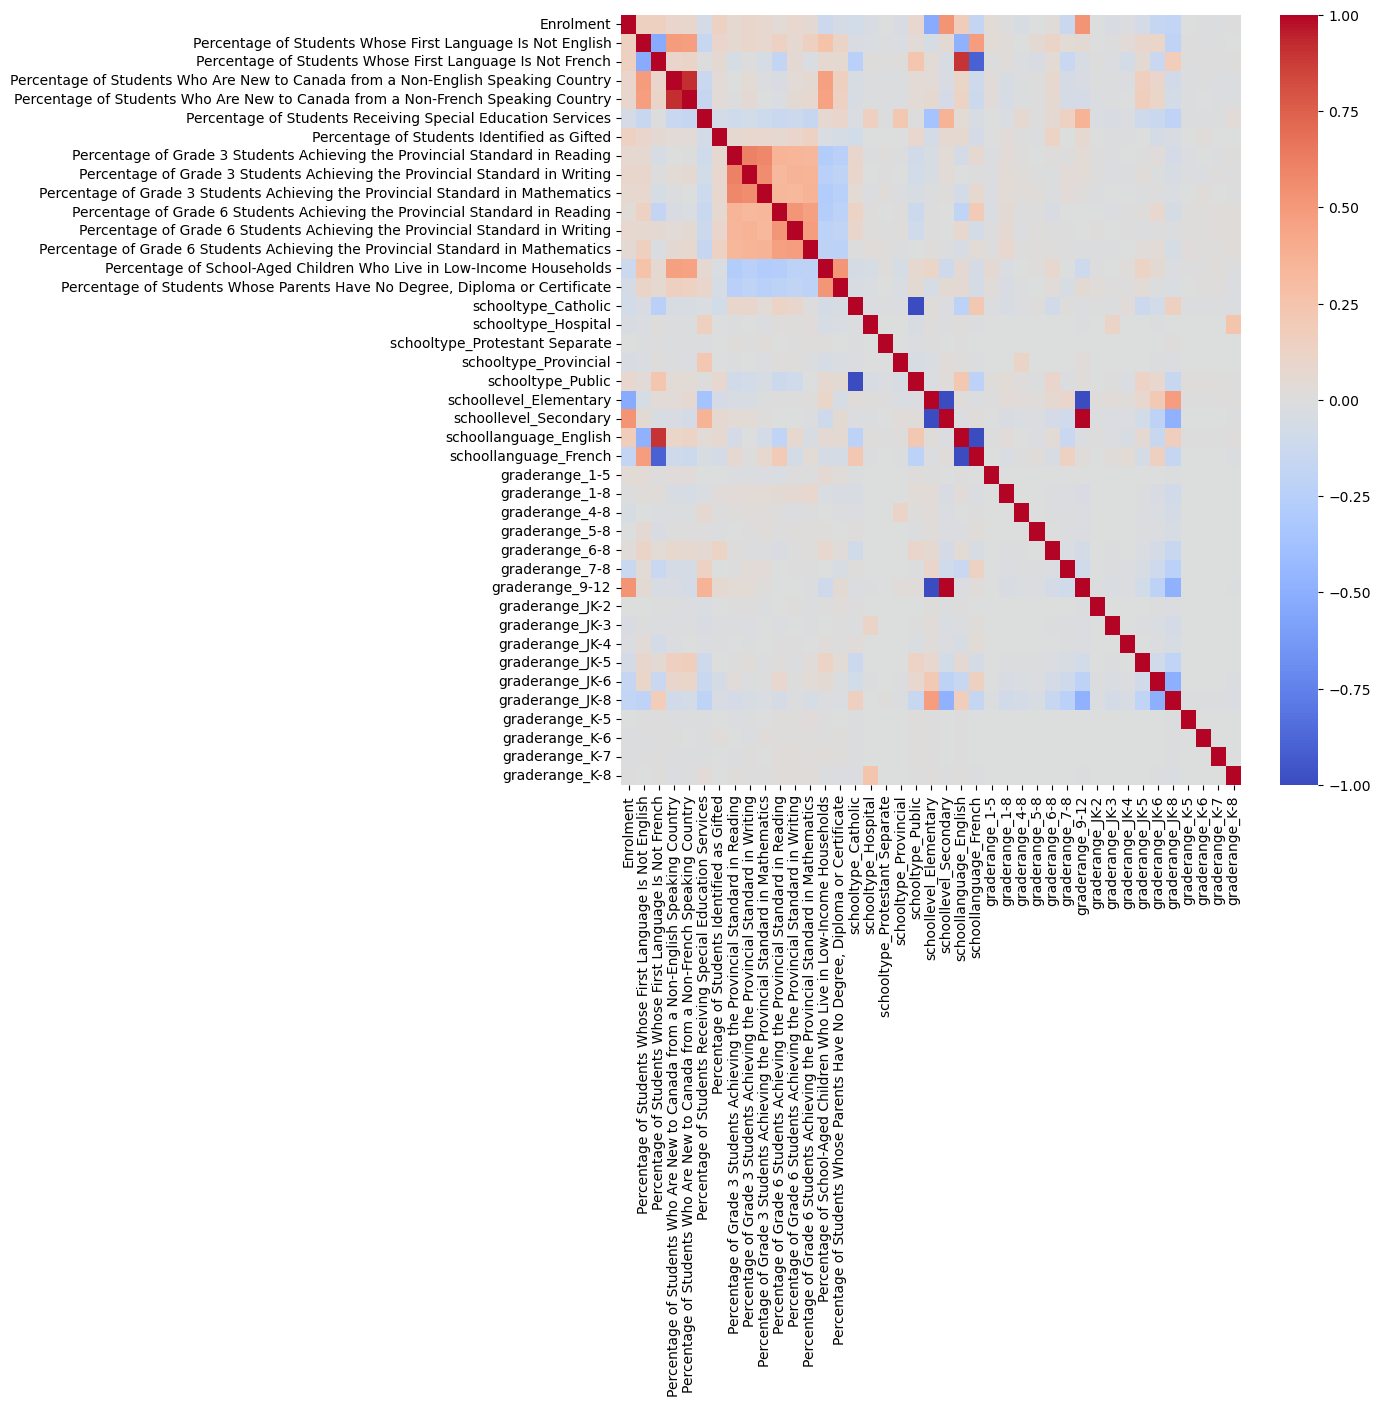

In [71]:
plt.subplots(figsize=(10, 10)) # Make the figure bigger so it shows all categories
sns.heatmap(schools.corr(), cmap="coolwarm")

In the matrix above, the fully red squares mean that those two column as related 1 to 1. That is, if one has a high value, the other will too. The fully blue squares are also heavily related but in the opposite direction. High values in one column means low values in the other. This still means they are correlated though. They are not independent.

You can see that the "achieving provincial standards" columns are all related with each other to a high degree. There is also a very heavy inverse correlation for having French spoken in schools vs having English spoken in schools.

All these heavy correlation violate the assumption that all columns are independent. It may be possible to increase the accuracy of the model by removing correlated columns which is definitely something you can try to play with. There is however still the possibility that there is simply no strong relation with the input columns and the "Percentage of Students Whose Parents Have No Degree, Diploma or Certificate" column we were trying to predict.

# Conclusion

In this tutorial, we have seen that we can use Naive Bayes to classify SMS text messages as spam or not and we have used it successfully to find what genres a particular book belongs. We've seen that Naive Bayes is particularly strong when it has a lot of feature columns to train on. We had 74169 columns for the SMS text messages and 90759 for the books and it worked great in that we could predict spam/not spam or what genres a book belongs to with high accuracy.

We have also seen that the algorithm can fail if the feature columns are too correlated which violates the basic assumption of Naive Bayes that all features are independent. We did learn a new imputation techinique where we take the distribution of known values as a probability distribution to impute missing values.